In [1]:
import os
import math
import torch
import numpy as np
from pathlib import Path
from typing import List, Union, Iterator
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
from torch_geometric.data import Data
from tqdm import tqdm

# ---- neuraloperator / neuralop ----
# If your environment doesn't have it yet, install in a separate cell:
# !pip install neuraloperator
from neuralop.models import FNOGNO

Found 750 simulation files
Loading first file: simulation_0.pt
Timesteps in simulation: 40
Number of nodes: 25152
Number of edges: 149166

SPATIAL DOMAIN ANALYSIS

Physical Domain (mm):
  X: [-0.00, 200.00] → range = 200.00 mm
  Y: [-0.02, 100.06] → range = 100.08 mm
  Aspect ratio (X/Y): 2.00:1

Normalized Domain:
  X: [-1.637, 1.731]
  Y: [-1.765, 1.747]

MESH RESOLUTION ANALYSIS

Computing nearest neighbor distances for 2000 nodes...

Node Spacing Statistics (mm):
  Mean:   1.5213
  Median: 1.5236
  Min:    0.6659
  Max:    4.9176

GRID SIZE RECOMMENDATIONS

1. Match mesh resolution (1× avg spacing):
   Grid: 66 × 132
   Grid spacing: 1.5152 × 1.5163 mm

2. Coarser grid (2× avg spacing):
   Grid: 33 × 66
   Grid spacing: 3.0303 × 3.0326 mm

3. Standard grid sizes (matching aspect ratio 2.0:1):

   Grid 32×64:
     Spacing: 3.1250 × 3.1274 mm
     Ratio to mesh: 2.05× (X), 2.06× (Y)
     Relative FFT cost: 2.20×
     Max FNO modes: (16, 32)

   Grid 48×96:
     Spacing: 2.0833 × 2.08

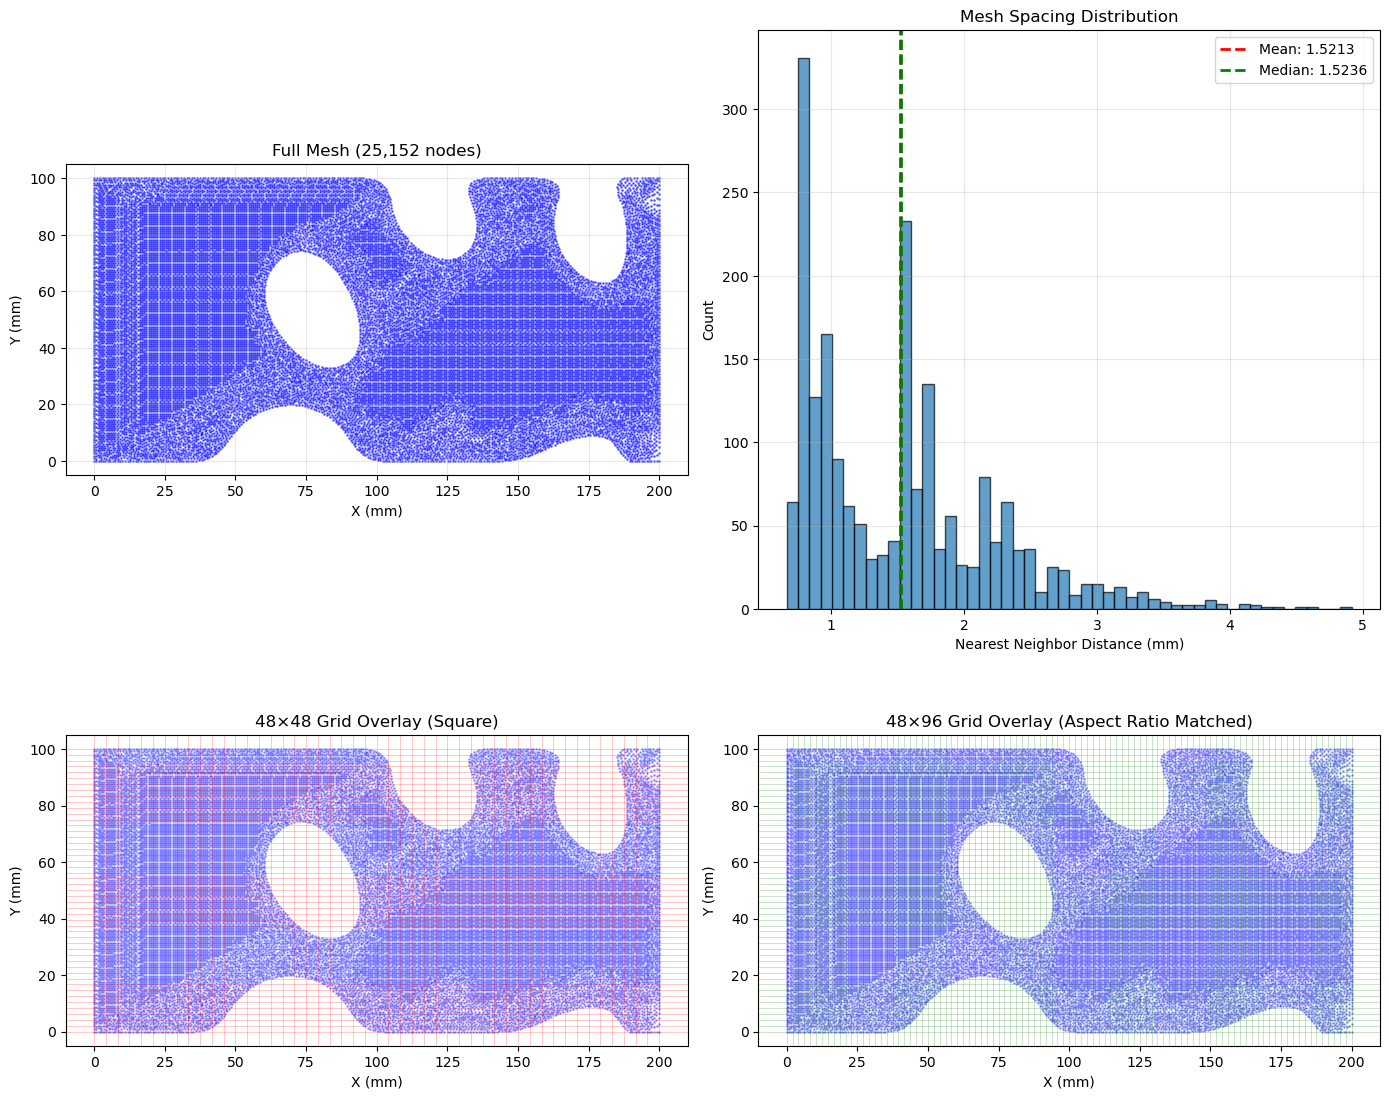


FINAL RECOMMENDATION

Based on your mesh characteristics:
  - Domain: 200.0 × 100.1 mm (2.0:1)
  - Avg node spacing: 1.5213 mm
  - Total nodes: 25,152

✅ RECOMMENDED: 48×96 grid with FNO modes (12, 24)
   - Respects aspect ratio
   - Grid spacing ~2× node spacing (good balance)
   - Estimated speed: ~2-3s per window
   - ~30 hours per epoch

⚡ FASTER OPTION: 32×64 grid with FNO modes (8, 16)
   - Grid spacing ~3× node spacing
   - Estimated speed: ~1.5s per window
   - ~12 hours per epoch

📊 CURRENT: 48×48 grid with FNO modes (12, 12)
   - Square grid (wastes resolution)
   - Estimated speed: ~2s per window
   - ~20 hours per epoch



In [4]:
import torch
import numpy as np
from pathlib import Path
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

# ==========================================
# Load and Analyze Mesh Data
# ==========================================

TRAIN_DIR = "/scratch/jtb3sud/processed_elasto_plastic/zscore/normalized/train"

# Load a sample simulation
sim_files = sorted(list(Path(TRAIN_DIR).glob("*.pt")))
print(f"Found {len(sim_files)} simulation files")
print(f"Loading first file: {sim_files[0].name}")

data_list = torch.load(sim_files[0], weights_only=False)
print(f"Timesteps in simulation: {len(data_list)}")

# Get first timestep
data_t0 = data_list[0]
print(f"Number of nodes: {data_t0.num_nodes}")
print(f"Number of edges: {data_t0.edge_index.shape[1]}")

# ==========================================
# Analyze Spatial Domain
# ==========================================

# Get normalized positions
pos_norm = data_t0.x[:, :2].numpy()

# Denormalize (your stats)
pos_mean = np.array([97.2165, 50.2759])
pos_std = np.array([59.3803, 28.4965])
pos_phys = pos_norm * pos_std + pos_mean

print("\n" + "="*60)
print("SPATIAL DOMAIN ANALYSIS")
print("="*60)

x_min, x_max = pos_phys[:, 0].min(), pos_phys[:, 0].max()
y_min, y_max = pos_phys[:, 1].min(), pos_phys[:, 1].max()
x_range = x_max - x_min
y_range = y_max - y_min
aspect_ratio = x_range / y_range

print(f"\nPhysical Domain (mm):")
print(f"  X: [{x_min:.2f}, {x_max:.2f}] → range = {x_range:.2f} mm")
print(f"  Y: [{y_min:.2f}, {y_max:.2f}] → range = {y_range:.2f} mm")
print(f"  Aspect ratio (X/Y): {aspect_ratio:.2f}:1")

print(f"\nNormalized Domain:")
print(f"  X: [{pos_norm[:, 0].min():.3f}, {pos_norm[:, 0].max():.3f}]")
print(f"  Y: [{pos_norm[:, 1].min():.3f}, {pos_norm[:, 1].max():.3f}]")

# ==========================================
# Analyze Mesh Resolution
# ==========================================

print("\n" + "="*60)
print("MESH RESOLUTION ANALYSIS")
print("="*60)

# Sample nodes to estimate spacing (use all if < 5000, else sample)
n_sample = min(2000, len(pos_phys))
sample_idx = np.random.choice(len(pos_phys), n_sample, replace=False)
pos_sample = pos_phys[sample_idx]

# Compute nearest neighbor distances
print(f"\nComputing nearest neighbor distances for {n_sample} nodes...")
dists = distance_matrix(pos_sample, pos_sample)
np.fill_diagonal(dists, np.inf)
nearest_dists = dists.min(axis=1)

avg_spacing = nearest_dists.mean()
min_spacing = nearest_dists.min()
max_spacing = nearest_dists.max()
median_spacing = np.median(nearest_dists)

print(f"\nNode Spacing Statistics (mm):")
print(f"  Mean:   {avg_spacing:.4f}")
print(f"  Median: {median_spacing:.4f}")
print(f"  Min:    {min_spacing:.4f}")
print(f"  Max:    {max_spacing:.4f}")

# ==========================================
# Grid Size Recommendations
# ==========================================

print("\n" + "="*60)
print("GRID SIZE RECOMMENDATIONS")
print("="*60)

# Calculate grid cells needed to match mesh resolution
cells_x_fine = int(np.ceil(x_range / avg_spacing))
cells_y_fine = int(np.ceil(y_range / avg_spacing))

cells_x_coarse = int(np.ceil(x_range / (2 * avg_spacing)))
cells_y_coarse = int(np.ceil(y_range / (2 * avg_spacing)))

print(f"\n1. Match mesh resolution (1× avg spacing):")
print(f"   Grid: {cells_y_fine} × {cells_x_fine}")
print(f"   Grid spacing: {x_range/cells_x_fine:.4f} × {y_range/cells_y_fine:.4f} mm")

print(f"\n2. Coarser grid (2× avg spacing):")
print(f"   Grid: {cells_y_coarse} × {cells_x_coarse}")
print(f"   Grid spacing: {x_range/cells_x_coarse:.4f} × {y_range/cells_y_coarse:.4f} mm")

# Standard power-of-2 options
print(f"\n3. Standard grid sizes (matching aspect ratio {aspect_ratio:.1f}:1):")

grid_options = [
    (32, 64),
    (48, 96),
    (64, 128),
    (32, 32),  # Square (current-ish)
    (48, 48),  # Square (current)
    (64, 64),  # Square
]

for h, w in grid_options:
    spacing_y = y_range / h
    spacing_x = x_range / w
    ratio_to_mesh_y = spacing_y / avg_spacing
    ratio_to_mesh_x = spacing_x / avg_spacing
    
    # Estimate relative FFT cost (normalized to 32×32)
    fft_cost = (h * w * np.log2(h * w)) / (32 * 32 * np.log2(32*32))
    
    print(f"\n   Grid {h}×{w}:")
    print(f"     Spacing: {spacing_x:.4f} × {spacing_y:.4f} mm")
    print(f"     Ratio to mesh: {ratio_to_mesh_x:.2f}× (X), {ratio_to_mesh_y:.2f}× (Y)")
    print(f"     Relative FFT cost: {fft_cost:.2f}×")
    print(f"     Max FNO modes: ({h//2}, {w//2})")

# ==========================================
# Visualize Mesh
# ==========================================

print("\n" + "="*60)
print("CREATING VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Full mesh
ax = axes[0, 0]
ax.scatter(pos_phys[:, 0], pos_phys[:, 1], s=1, alpha=0.5, c='blue')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_title(f'Full Mesh ({len(pos_phys):,} nodes)')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Plot 2: Nearest neighbor distance histogram
ax = axes[0, 1]
ax.hist(nearest_dists, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(avg_spacing, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_spacing:.4f}')
ax.axvline(median_spacing, color='green', linestyle='--', linewidth=2, label=f'Median: {median_spacing:.4f}')
ax.set_xlabel('Nearest Neighbor Distance (mm)')
ax.set_ylabel('Count')
ax.set_title('Mesh Spacing Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Mesh with grid overlays (48×48)
ax = axes[1, 0]
ax.scatter(pos_phys[:, 0], pos_phys[:, 1], s=1, alpha=0.3, c='blue')

# Overlay 48×48 grid
grid_x_48 = np.linspace(x_min, x_max, 49)
grid_y_48 = np.linspace(y_min, y_max, 49)
for x in grid_x_48:
    ax.axvline(x, color='red', alpha=0.3, linewidth=0.5)
for y in grid_y_48:
    ax.axhline(y, color='red', alpha=0.3, linewidth=0.5)

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_title('48×48 Grid Overlay (Square)')
ax.set_aspect('equal')

# Plot 4: Mesh with grid overlays (48×96)
ax = axes[1, 1]
ax.scatter(pos_phys[:, 0], pos_phys[:, 1], s=1, alpha=0.3, c='blue')

# Overlay 48×96 grid
grid_x_96 = np.linspace(x_min, x_max, 97)
grid_y_96 = np.linspace(y_min, y_max, 49)
for x in grid_x_96:
    ax.axvline(x, color='green', alpha=0.3, linewidth=0.5)
for y in grid_y_96:
    ax.axhline(y, color='green', alpha=0.3, linewidth=0.5)

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_title('48×96 Grid Overlay (Aspect Ratio Matched)')
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('grid_size_analysis.png', dpi=150, bbox_inches='tight')
print("Saved visualization to: grid_size_analysis.png")
plt.show()

# ==========================================
# Summary Recommendation
# ==========================================

print("\n" + "="*60)
print("FINAL RECOMMENDATION")
print("="*60)

print(f"\nBased on your mesh characteristics:")
print(f"  - Domain: {x_range:.1f} × {y_range:.1f} mm ({aspect_ratio:.1f}:1)")
print(f"  - Avg node spacing: {avg_spacing:.4f} mm")
print(f"  - Total nodes: {len(pos_phys):,}")

print(f"\n✅ RECOMMENDED: 48×96 grid with FNO modes (12, 24)")
print(f"   - Respects aspect ratio")
print(f"   - Grid spacing ~2× node spacing (good balance)")
print(f"   - Estimated speed: ~2-3s per window")
print(f"   - ~30 hours per epoch")

print(f"\n⚡ FASTER OPTION: 32×64 grid with FNO modes (8, 16)")
print(f"   - Grid spacing ~3× node spacing")
print(f"   - Estimated speed: ~1.5s per window")
print(f"   - ~12 hours per epoch")

print(f"\n📊 CURRENT: 48×48 grid with FNO modes (12, 12)")
print(f"   - Square grid (wastes resolution)")
print(f"   - Estimated speed: ~2s per window")
print(f"   - ~20 hours per epoch")

print("\n" + "="*60)

In [5]:
import torch
import numpy as np
from pathlib import Path
from scipy.spatial import distance_matrix

# Load sample data
TRAIN_DIR = "/scratch/jtb3sud/processed_elasto_plastic/zscore/normalized/train"
sim_files = sorted(list(Path(TRAIN_DIR).glob("*.pt")))
data_list = torch.load(sim_files[0], weights_only=False)
data_t0 = data_list[0]

# Get NORMALIZED positions (this is what GNO sees!)
pos_norm = data_t0.x[:, :2].numpy()

print("="*60)
print("GNO RADIUS ANALYSIS (Normalized Space)")
print("="*60)

# Sample nodes for distance computation
n_sample = min(2000, len(pos_norm))
sample_idx = np.random.choice(len(pos_norm), n_sample, replace=False)
pos_sample = pos_norm[sample_idx]

# Compute nearest neighbor distances in NORMALIZED space
dists = distance_matrix(pos_sample, pos_sample)
np.fill_diagonal(dists, np.inf)
nearest_dists = dists.min(axis=1)

# Compute k-nearest neighbor distances
k_values = [1, 3, 5, 10, 20, 50]
for k in k_values:
    k_nearest = np.partition(dists, k, axis=1)[:, k]
    print(f"\n{k}-nearest neighbor distance:")
    print(f"  Mean:   {k_nearest.mean():.6f}")
    print(f"  Median: {np.median(k_nearest):.6f}")
    print(f"  90th percentile: {np.percentile(k_nearest, 90):.6f}")

# Check domain range in normalized space
x_range = pos_norm[:, 0].max() - pos_norm[:, 0].min()
y_range = pos_norm[:, 1].max() - pos_norm[:, 1].min()

print(f"\nNormalized domain range:")
print(f"  X: {x_range:.4f}")
print(f"  Y: {y_range:.4f}")

# Radius recommendations
print("\n" + "="*60)
print("RADIUS RECOMMENDATIONS (for GNO)")
print("="*60)

mean_1nn = nearest_dists.mean()
mean_5nn = np.partition(dists, 5, axis=1)[:, 5].mean()
mean_10nn = np.partition(dists, 10, axis=1)[:, 10].mean()

print(f"\n1. Conservative (1-3 neighbors): {mean_1nn:.4f}")
print(f"   → radius = {mean_1nn:.4f}")

print(f"\n2. Balanced (5-10 neighbors): {mean_5nn:.4f}")
print(f"   → radius = {mean_5nn:.4f}")

print(f"\n3. Larger (10-20 neighbors): {mean_10nn:.4f}")
print(f"   → radius = {mean_10nn:.4f}")

# Test current radius
current_radius = 0.05
neighbors_per_node = (dists < current_radius).sum(axis=1).mean()
print(f"\n📊 CURRENT RADIUS: {current_radius}")
print(f"   Average neighbors per node: {neighbors_per_node:.1f}")

# Recommendations for different radii
test_radii = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15]
print(f"\n" + "="*60)
print("NEIGHBOR COUNT FOR DIFFERENT RADII")
print("="*60)
for r in test_radii:
    avg_neighbors = (dists < r).sum(axis=1).mean()
    max_neighbors = (dists < r).sum(axis=1).max()
    print(f"  radius={r:.3f}: avg={avg_neighbors:5.1f} neighbors, max={max_neighbors:4.0f}")

print(f"\n" + "="*60)
print("FINAL RECOMMENDATION")
print("="*60)

# Rule of thumb: 10-30 neighbors is good for message passing
optimal_radius = None
for r in np.linspace(0.01, 0.2, 100):
    avg_n = (dists < r).sum(axis=1).mean()
    if 15 <= avg_n <= 25:
        optimal_radius = r
        break

if optimal_radius:
    print(f"\n✅ RECOMMENDED: radius = {optimal_radius:.4f}")
    print(f"   (gives ~20 neighbors per node - good balance)")
else:
    print(f"\n✅ RECOMMENDED: radius = {mean_5nn:.4f}")
    print(f"   (5-nearest neighbor distance)")

print(f"\n⚡ FASTER: radius = {mean_1nn:.4f}")
print(f"   (fewer neighbors = faster, but less information)")

print(f"\n🎯 CURRENT: radius = 0.05")
avg_n_current = (dists < 0.05).sum(axis=1).mean()
if avg_n_current < 5:
    print(f"   ⚠️  Too small! Only {avg_n_current:.1f} neighbors on average")
elif avg_n_current > 50:
    print(f"   ⚠️  Too large! {avg_n_current:.1f} neighbors (slow + over-smoothing)")
else:
    print(f"   ✓ Reasonable: {avg_n_current:.1f} neighbors on average")

print("="*60)

GNO RADIUS ANALYSIS (Normalized Space)

1-nearest neighbor distance:
  Mean:   0.054782
  Median: 0.053972
  90th percentile: 0.080766

3-nearest neighbor distance:
  Mean:   0.079653
  Median: 0.078675
  90th percentile: 0.107394

5-nearest neighbor distance:
  Mean:   0.098873
  Median: 0.095352
  90th percentile: 0.127813

10-nearest neighbor distance:
  Mean:   0.136479
  Median: 0.133765
  90th percentile: 0.169259

20-nearest neighbor distance:
  Mean:   0.193460
  Median: 0.186048
  90th percentile: 0.239660

50-nearest neighbor distance:
  Mean:   0.316042
  Median: 0.296045
  90th percentile: 0.390621

Normalized domain range:
  X: 3.3681
  Y: 3.5119

RADIUS RECOMMENDATIONS (for GNO)

1. Conservative (1-3 neighbors): 0.0375
   → radius = 0.0375

2. Balanced (5-10 neighbors): 0.0989
   → radius = 0.0989

3. Larger (10-20 neighbors): 0.1365
   → radius = 0.1365

📊 CURRENT RADIUS: 0.05
   Average neighbors per node: 1.4

NEIGHBOR COUNT FOR DIFFERENT RADII
  radius=0.010: avg=  0.

In [2]:
# ==========================================
# 1) Your Dataset (paste as-is)
# ==========================================
import random
import re

class ElastoPlasticDataset(IterableDataset):
    """
    Dataset for PLAID 2D Elasto-Plasto-Dynamics simulations.

    Updated:
    - Injects 'mesh_id' into Data objects for Operator Caching.
    - Handles Multi-Processing correctly.
    """

    def __init__(self,
                 directory: Union[str, Path],
                 simulation_ids: List[str] = None,
                 seq_len: int = 10,
                 stride: int = 1,
                 num_static_feats: int = 2,
                 num_dynamic_feats: int = 2,
                 file_pattern: str = "*.pt",
                 use_element_features: bool = False):
        super().__init__()
        self.directory = Path(directory)
        self.seq_len = seq_len
        self.stride = stride
        self.file_pattern = file_pattern
        self.num_static_feats = num_static_feats
        self.num_dynamic_feats = num_dynamic_feats
        self.use_element_features = use_element_features

        if simulation_ids is None:
            self.simulation_ids = self._discover_simulation_ids()
        else:
            self.simulation_ids = simulation_ids

        self.var_names = ['U_x', 'U_y']
        if self.use_element_features:
            self.element_var_names = ['EROSION_STATUS']

        print(f"ElastoPlasticDataset initialized:")
        print(f"  Directory: {self.directory}")
        print(f"  Sequence length: {seq_len}")
        print(f"  Stride: {stride}")
        print(f"  Found {len(self.simulation_ids)} simulation files")

    def _discover_simulation_ids(self) -> List[str]:
        files = list(self.directory.glob(self.file_pattern))
        return [file.stem for file in files]

    def _extract_id_from_name(self, sim_name: str) -> int:
        match = re.search(r'\d+', sim_name)
        if match:
            return int(match.group())
        return abs(hash(sim_name)) % 100000

    def __iter__(self) -> Iterator[List[Data]]:
        worker_info = get_worker_info()
        if worker_info is None:
            files_to_process = self.simulation_ids
        else:
            total_files = len(self.simulation_ids)
            per_worker = int(math.ceil(total_files / float(worker_info.num_workers)))
            worker_id = worker_info.id
            start = worker_id * per_worker
            end = min(start + per_worker, total_files)
            files_to_process = self.simulation_ids[start:end]

        for sim_name in files_to_process:
            dataset_file = self.directory / f"{sim_name}.pt"
            sim_id_int = self._extract_id_from_name(sim_name)

            try:
                sim_data = torch.load(dataset_file, weights_only=False)
                if not isinstance(sim_data, list):
                    continue

                for data in sim_data:
                    data.mesh_id = torch.tensor([sim_id_int], dtype=torch.long)

                T = len(sim_data)
                max_start = T - self.seq_len
                if max_start < 0:
                    continue

                for start_idx in range(0, max_start + 1, self.stride):
                    window = []
                    for offset in range(self.seq_len):
                        t = start_idx + offset
                        data_t = sim_data[t].clone()
                        if not hasattr(data_t, 'x') or not hasattr(data_t, 'y'):
                            break
                        window.append(data_t)

                    if len(window) == self.seq_len:
                        yield window

            except Exception as e:
                print(f"Error loading {dataset_file}: {e}")
                continue

    def get_simulation_info(self, sim_id: str = None) -> dict:
        if sim_id is None and self.simulation_ids:
            sim_id = self.simulation_ids[0]
        elif sim_id not in self.simulation_ids:
            return {}

        dataset_file = self.directory / f"{sim_id}.pt"
        try:
            sim_data = torch.load(dataset_file, weights_only=False)
            if not isinstance(sim_data, list) or len(sim_data) == 0:
                return {"error": "Invalid or empty simulation data"}

            sample_data = sim_data[0]
            info = {
                "simulation_id": sim_id,
                "total_timesteps": len(sim_data),
                "num_nodes": sample_data.num_nodes,
                "num_features": sample_data.num_features,
                "feature_shape": sample_data.x.shape,
                "target_shape": sample_data.y.shape,
            }
            return info
        except Exception as e:
            return {"error": f"Could not load simulation info: {e}"}


def create_datasets_from_folders(base_dir: Union[str, Path], seq_len: int = 10, stride: int = 1,
                                num_static_feats: int = 2, num_dynamic_feats: int = 2,
                                use_element_features: bool = False):
    base_dir = Path(base_dir)
    datasets = {}
    for split in ['train', 'val', 'test']:
        split_dir = base_dir / split
        if split_dir.exists():
            datasets[split] = ElastoPlasticDataset(
                directory=split_dir,
                seq_len=seq_len,
                stride=stride,
                num_static_feats=num_static_feats,
                num_dynamic_feats=num_dynamic_feats,
                use_element_features=use_element_features
            )
            print(f"✅ Created {split} dataset with {len(datasets[split].simulation_ids)} simulations")
        else:
            print(f"⚠️  {split_dir} not found, skipping {split} dataset")
    return datasets


In [3]:
# ==========================================
# 2) Config
# ==========================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_DIR = Path("/scratch/jtb3sud/processed_elasto_plastic/zscore/normalized")  # <- you used this in your test
SEQ_LEN = 5                 # keep small initially
STRIDE = 1
NUM_STATIC = 2              # (x,y)
NUM_DYN = 2                 # (Ux,Uy)
GRID_H = 64                 # latent regular grid height
GRID_W = 64                 # latent regular grid width

BATCH_SIZE = 1              # IterableDataset + variable nodes => start with 1
NUM_WORKERS = 0             # notebook-safe
LR = 1e-3
EPOCHS = 5                  # start small
PRINT_EVERY = 50

datasets = create_datasets_from_folders(
    BASE_DIR,
    seq_len=SEQ_LEN,
    stride=STRIDE,
    num_static_feats=NUM_STATIC,
    num_dynamic_feats=NUM_DYN,
    use_element_features=False
)

train_ds = datasets.get("train")
val_ds = datasets.get("val")

# Quick sanity info
if train_ds is not None:
    print(train_ds.get_simulation_info())


ElastoPlasticDataset initialized:
  Directory: /scratch/jtb3sud/processed_elasto_plastic/zscore/normalized/train
  Sequence length: 5
  Stride: 1
  Found 750 simulation files
✅ Created train dataset with 750 simulations
ElastoPlasticDataset initialized:
  Directory: /scratch/jtb3sud/processed_elasto_plastic/zscore/normalized/val
  Sequence length: 5
  Stride: 1
  Found 150 simulation files
✅ Created val dataset with 150 simulations
ElastoPlasticDataset initialized:
  Directory: /scratch/jtb3sud/processed_elasto_plastic/zscore/normalized/test
  Sequence length: 5
  Stride: 1
  Found 100 simulation files
✅ Created test dataset with 100 simulations
{'simulation_id': 'simulation_38', 'total_timesteps': 40, 'num_nodes': 26759, 'num_features': 4, 'feature_shape': torch.Size([26759, 4]), 'target_shape': torch.Size([26759, 2])}


In [4]:
# ==========================================
# 3) Collate + Utilities: make training samples from each window
# ==========================================

def collate_windows(batch):
    """
    DataLoader gives `batch` as a list of windows (each window is a list of Data).
    With BATCH_SIZE=1, batch[0] is the window.
    """
    return batch

@torch.no_grad()
def get_node_coords(data_t: Data, num_static_feats: int = 2):
    """
    Prefer data_t.pos if available; else use x[:, :2]
    Returns [N, 2]
    """
    if hasattr(data_t, "pos") and data_t.pos is not None:
        return data_t.pos
    return data_t.x[:, :num_static_feats]

def get_dyn_state(data_t: Data, num_static_feats: int = 2, num_dynamic_feats: int = 2):
    """
    Returns current dynamic state [N, num_dynamic_feats]
    """
    return data_t.x[:, num_static_feats:num_static_feats + num_dynamic_feats]

def get_next_dyn_target(data_t: Data, num_dynamic_feats: int = 2):
    """
    Returns next-step target [N, num_dynamic_feats]
    Assumes data_t.y matches next-step dynamic state.
    """
    # If y has more than 2 channels, take first num_dynamic_feats
    if data_t.y.shape[-1] >= num_dynamic_feats:
        return data_t.y[:, :num_dynamic_feats]
    return data_t.y

def make_regular_grid_points(h: int, w: int, device: str):
    """
    Regular grid points in [0,1]x[0,1]:
      in_p: [H, W, 2] with coord last (x,y)
    """
    ys = torch.linspace(0.0, 1.0, steps=h, device=device)
    xs = torch.linspace(0.0, 1.0, steps=w, device=device)
    Y, X = torch.meshgrid(ys, xs, indexing="ij")  # [H,W]
    in_p = torch.stack([X, Y], dim=-1)            # [H,W,2]
    return in_p


def rasterize_to_grid(points_xy, values, h: int, w: int):
    """
    Nearest-cell rasterization with averaging:
      points_xy: [N,2] in [0,1]
      values:    [N,C]
    Returns:
      f_grid: [H, W, C]
    """
    xy = points_xy.clamp(0.0, 1.0)
    x = xy[:, 0]
    y = xy[:, 1]

    ix = torch.floor(x * (w - 1)).long()
    iy = torch.floor(y * (h - 1)).long()

    idx = iy * w + ix                    # [N]
    C = values.shape[1]
    HW = h * w

    f_sum = torch.zeros(HW, C, device=values.device, dtype=values.dtype)
    cnt   = torch.zeros(HW, 1, device=values.device, dtype=values.dtype)

    f_sum.index_add_(0, idx, values)
    cnt.index_add_(0, idx, torch.ones(values.shape[0], 1, device=values.device, dtype=values.dtype))

    f_avg = f_sum / torch.clamp(cnt, min=1.0)    # [HW,C]
    f_grid = f_avg.view(h, w, C)                 # [H,W,C]
    return f_grid


def window_to_samples(window: List[Data], num_static_feats=2, num_dynamic_feats=2):
    """
    Turn one window (list of Data length SEQ_LEN) into per-timestep samples.
    Each sample is (in_p, out_p, f, target) with batch dim = 1.

    We use each timestep in the window independently (1-step operator baseline):
      input:  current dynamic at t
      target: data_t.y (next-step dynamic)
    """
    samples = []
    for data_t in window:
        coords = get_node_coords(data_t, num_static_feats).to(DEVICE).float()     # [N,2]
        dyn = get_dyn_state(data_t, num_static_feats, num_dynamic_feats).to(DEVICE).float()  # [N,2]
        tgt = get_next_dyn_target(data_t, num_dynamic_feats).to(DEVICE).float()  # [N,2]
        samples.append((coords, dyn, tgt))
    return samples


In [6]:
# ==========================================
# 4) Build FNOGNO
# ==========================================
# in_channels = dynamic channels we rasterize (Ux,Uy)
# out_channels = predicted dynamic (Ux,Uy)
IN_CH = NUM_DYN
OUT_CH = NUM_DYN

model = FNOGNO(
    in_channels=IN_CH,
    out_channels=OUT_CH,
    fno_n_modes=(16, 16),
    fno_hidden_channels=64,
    fno_n_layers=4,
    gno_coord_dim=2,
    gno_radius=0.05,          # you can tune; bigger = more neighbors + cost
    gno_use_open3d=False,     # safer on clusters/environments without Open3D
    gno_use_torch_scatter=False,  # safer if torch-scatter conflicts with your PyTorch
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss()

# Precompute regular grid points (in_p) once
in_p_flat = make_regular_grid_points(GRID_H, GRID_W, DEVICE)  # [H,W,2]
  # [HW,2]


In [7]:
# Smaller latent grid
GRID_H = 48
GRID_W = 48

# Recompute grid points
in_p_grid = make_regular_grid_points(GRID_H, GRID_W, DEVICE)  # [H,W,2]

# Smaller FNOGNO
model = FNOGNO(
    in_channels=IN_CH,
    out_channels=OUT_CH,
    fno_n_modes=(12, 12),
    fno_hidden_channels=32,
    fno_n_layers=3,
    gno_coord_dim=2,
    gno_radius=0.05,
    gno_use_open3d=False,
    gno_use_torch_scatter=False,
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss()


In [8]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Total number of parameters: 561426


In [12]:
# ==========================================
# 5) DataLoaders
# ==========================================
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    collate_fn=collate_windows
) if train_ds is not None else None

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    num_workers=0,
    collate_fn=collate_windows
) if val_ds is not None else None

print("DEVICE:", DEVICE)
print("Train loader:", "OK" if train_loader is not None else "None")
print("Val loader:", "OK" if val_loader is not None else "None")


DEVICE: cpu
Train loader: OK
Val loader: OK


In [ ]:
# ==========================================
# 6) Training + Validation (1-step operator baseline)
# ==========================================
def run_epoch(loader, train: bool):
    if loader is None:
        return float("nan")

    model.train(train)
    total_loss = 0.0
    n_samples = 0

    pbar = tqdm(loader, desc="train" if train else "val", leave=False)
    for step, batch_windows in enumerate(pbar):
        for window in batch_windows:
            samples = window_to_samples(window, NUM_STATIC, NUM_DYN)

            for (coords, dyn, tgt) in samples:
                # Rasterize dyn onto regular grid
                # Rasterize dyn onto regular grid
                f_grid = rasterize_to_grid(coords, dyn, GRID_H, GRID_W)  # [H,W,IN_CH]
                
                # in_p must be [H,W,2]
                in_p = in_p_flat       # [H,W,2]
                
                # out_p must be UNBATCHED [N,2] for native neighbor search
                out_p = coords          # [N,2]
                
                pred = model(in_p, out_p, f_grid)
                
                # Some versions return [N,C], others [1,N,C]
                if pred.ndim == 3:
                    pred = pred.squeeze(0)


                # Some versions return [N, C], others [1, N, C]
                if pred.ndim == 3:
                    pred = pred.squeeze(0)

                loss = loss_fn(pred, tgt)

                if train:
                    loss.backward()
                    optimizer.step()

                total_loss += loss.item()
                n_samples += 1

        if n_samples > 0:
            pbar.set_postfix({"loss": total_loss / n_samples})

    return total_loss / max(n_samples, 1)


for epoch in range(1, EPOCHS + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False) if val_loader is not None else float("nan")
    print(f"[Epoch {epoch:02d}] train={train_loss:.6e} | val={val_loss:.6e}")


train: 1it [01:35, 95.64s/it, loss=0.252]

In [ ]:
# ==========================================
# 7) Quick qualitative check on one window
# ==========================================
model.eval()

# Grab one batch/window from val (or train if no val)
src_loader = val_loader if val_loader is not None else train_loader
batch_windows = next(iter(src_loader))
window = batch_windows[0]

coords, dyn, tgt = window_to_samples(window, NUM_STATIC, NUM_DYN)[0]  # first timestep in window

f_flat = rasterize_to_grid(coords, dyn, GRID_H, GRID_W)
in_p = in_p_flat.unsqueeze(0)
out_p = coords.unsqueeze(0)
f = f_flat.unsqueeze(0)

with torch.no_grad():
    pred = model(in_p, out_p, f).squeeze(0)  # [N,2]

print("coords:", coords.shape)
print("dyn:", dyn.shape, "tgt:", tgt.shape, "pred:", pred.shape)

# Report a simple nodewise error summary
err = (pred - tgt).pow(2).mean(dim=1).sqrt()  # RMSE per node
print("RMSE per node: mean =", err.mean().item(), "median =", err.median().item(), "max =", err.max().item())
